<a href="https://colab.research.google.com/github/nghessss/detect_emo/blob/main/Vietnamese_Sentiment_Analyst_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install --upgrade tensorflow
!pip install pyvi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from pyvi import ViTokenizer
from sklearn import metrics
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from os import getcwd
nltk.download('stopwords')

# @title
# add folder, tmp2, from our local workspace containing pre-downloaded corpora files to nltk's data path
filePath = f"{getcwd()}/../tmp2/"
nltk.data.path.append(filePath)
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


# data preprocessing

In [5]:
# @title
def data_preprocessing(sentence):
    sentence = re.sub(r'[,!?;-]+', '.', str(sentence))
    sentence = sentence.lower()
    sentence = ViTokenizer.tokenize(sentence) # gộp các từ có nghĩa lại với nhau
    sentence = nltk.word_tokenize(sentence)
    return sentence

In [6]:

from sklearn.model_selection import train_test_split

# Assuming you have imported the necessary libraries and defined the preprocessing function 'data_preprocessing'

# Load the data from the CSV file
df = pd.read_csv('drive/MyDrive/data/new_data.csv', encoding='utf-8')

# Extract the content and labels from the DataFrame
content = df.iloc[:, 0].values
label = df.iloc[:, 2].values

train_content, test_content, train_label, test_label = train_test_split(content, label, test_size=0.2, random_state=42)
train_content, valid_content, train_label, valid_label = train_test_split(train_content, train_label, test_size = .2, shuffle = True, stratify=train_label)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer = data_preprocessing,ngram_range=(1,4), min_df=5, max_df= 0.8, max_features= 5000, sublinear_tf=True)
train_content = vectorizer.fit_transform(train_content).toarray()
test_content  = vectorizer.transform(test_content).toarray()
valid_content = vectorizer.transform(valid_content).toarray()


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [8]:
def reshapeLabelData(label):
  pass

# training

In [9]:
from keras import backend as K
import tensorflow as tf
from keras.layers import Input, Dense, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import optimizers
DROPOUT = 0.3
ACTIVATION = "relu"

model = Sequential([
    Dense(1024, activation=ACTIVATION, input_dim = train_content.shape[1]),
    Dropout(DROPOUT),
    Dense(512, activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(256, activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(5, activation='linear'),
])

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
from keras.optimizers import Adam
adam = Adam()

# Compile your model with the optimizer
model.compile(optimizer=adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()
es = EarlyStopping(monitor='val_f1_m', mode='max', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', factor=0.2, patience=8, min_lr=1e7)
checkpoint = ModelCheckpoint('best_full.keras', monitor='val_f1_m', verbose=0, save_best_only=False, save_weights_only=False, mode='auto',save_freq='epoch')



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │       5,121,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,778,437 (22.04 MB)

 Trainable params: 5,778,437 (22.04 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
train_label = train_label.reshape(len(train_label),1)
valid_label = valid_label.reshape(len(valid_label),1)

In [12]:
train_label = train_label - 1
valid_label = valid_label - 1
test_label = test_label - 1

In [13]:
valid_content.shape

(5034, 5000)

In [14]:
train_label

array([[0],
       [0],
       [1],
       ...,
       [4],
       [4],
       [2]])

In [15]:
EPOCHS = 25
BATCHSIZE = 4
model.fit(train_content, train_label, epochs=EPOCHS, batch_size=BATCHSIZE, validation_data=(valid_content, valid_label), callbacks=[es, reduce_lr, checkpoint])

Epoch 1/25
5034/5034 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5135 - loss: 1.1293

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_f1_m` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_f1_m` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


5034/5034 ━━━━━━━━━━━━━━━━━━━━ 415s 82ms/step - accuracy: 0.5135 - loss: 1.1293 - val_accuracy: 0.5665 - val_loss: 1.0144 - learning_rate: 0.0010
Epoch 2/25
5034/5034 ━━━━━━━━━━━━━━━━━━━━ 395s 73ms/step - accuracy: 0.6113 - loss: 0.9199 - val_accuracy: 0.5687 - val_loss: 1.0075 - learning_rate: 0.0010
Epoch 3/25
5034/5034 ━━━━━━━━━━━━━━━━━━━━ 396s 75ms/step - accuracy: 0.6560 - loss: 0.8200 - val_accuracy: 0.5596 - val_loss: 1.0641 - learning_rate: 0.0010
Epoch 4/25
5034/5034 ━━━━━━━━━━━━━━━━━━━━ 375s 74ms/step - accuracy: 0.7405 - loss: 0.6751 - val_accuracy: 0.5532 - val_loss: 1.2362 - learning_rate: 0.0010
Epoch 5/25
5034/5034 ━━━━━━━━━━━━━━━━━━━━ 379s 74ms/step - accuracy: 0.7877 - loss: 0.5469 - val_accuracy: 0.5578 - val_loss: 1.4196 - learning_rate: 0.0010
Epoch 6/25
5034/5034 ━━━━━━━━━━━━━━━━━━━━ 387s 74ms/step - accuracy: 0.8270 - loss: 0.4602 - val_accuracy: 0.5513 - val_loss: 1.6518 - learning_rate: 0.0010
Epoch 7/25
5034/5034 ━━━━━━━━━━━━━━━━━━━━ 414s 81ms/step - accuracy: 

In [16]:
predict_test = model.predict(test_content)

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


In [17]:
def rate_to_label(rate):
    if isinstance(rate, np.ndarray):
        labels = []
        for r in rate:
            if r < 2:
                labels.append('negative')
            elif r == 2:
                labels.append('neutral')
            else:
                labels.append('positive')
        return np.array(labels)
    else:
        if rate < 2:
            return 'negative'
        elif rate == 2:
            return 'neutral'
        else:
            return 'positive'


In [18]:
predict = predict_test.argmax(-1)
predict = rate_to_label(predict)

In [19]:
test_label = rate_to_label(test_label)

Text(0.5, 58.7222222222222, 'Predicted')

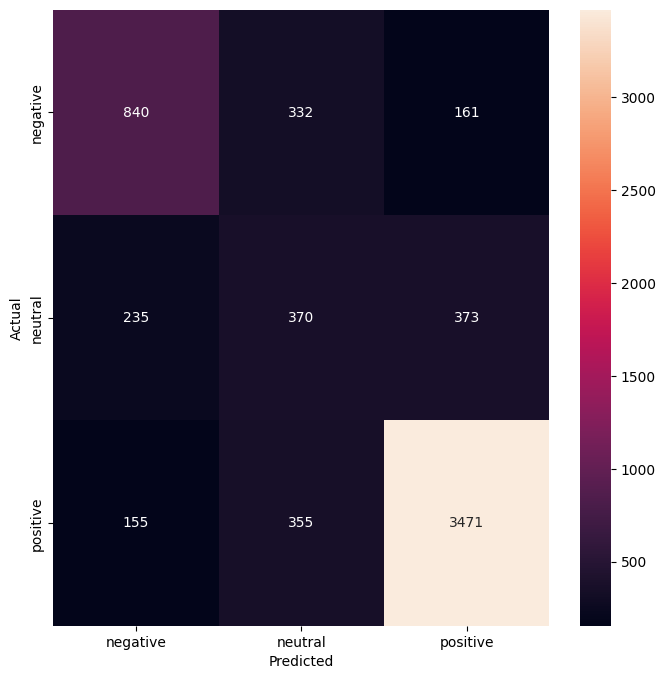

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(8, 8))
conf_mat = confusion_matrix(test_label, predict)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(test_label), yticklabels=np.unique(predict))
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [21]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score


In [22]:
recall_score(test_label, predict, average='weighted')

0.7439605848696758

In [23]:
accuracy_score(test_label, predict)

0.7439605848696758

In [24]:
f1_score(test_label, predict, average='weighted')

0.7453850007289213

In [28]:
model.save('Nghes_Vietnamese_Sentiment_Analyst_base.keras')